In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv("~/Repositories/datasets/analytics_p2p_registrations.csv")
drop_cols = ['product', 'sms_trans_vol', 'p2p_trans_vol', 'kiosk_trans_vol', 
             'fb_trans_count', 'sms_trans_count', 'kiosk_trans_count', 'p2p_trans_count', 
             'mobile_visits', 'vt_trans_count', 'vt_trans_vol', 'don_form_trans_count', 
             'don_form_trans_vol', 'form', 'org', 'id', 'fb_trans_vol', 
             'one_time_trans_count', 'one_time_trans_vol', 'rec_trans_count', 
             'rec_trans_vol', 'mobile_trans_count', 'mobile_trans_vol', 
             'mobilevt_trans_count', 'mobilevt_trans_vol', 'reg_volume', 
             'don_volume', 'don_count']
df = df.drop(drop_cols, axis=1)

# the following are missing all data so dropping for clean views
more_drop_cols = ['share_home', 'share_pfp', 'share_tfp', 'share_therm', 'share_donation', 
                  'allows_soc_post_pfp_tcp', 'social_templt_count', 'social_auto', 
                  'pcnt_posts', 'mon_posts', 'count_posts', 'date_posts', 'email_templt_count']
df = df.drop(more_drop_cols, axis=1)

# no disparity between values (ie, settings almost universally identifal to all observations 
# or has no impact)
further_drop_cols = ['allows_social', 'allows_sub_reg', 'allows_other_don_amt']
df = df.drop(further_drop_cols, axis=1)

# set binary features to binary just in case another value (ie, 5 for inactive) slipped in
for c in df.columns:
    if 'allows' in c:
        df[c] = df[c].apply(lambda x: 0 if x == 5 else x)

df = df[df.visits>0]
# adding conversion variable
df['reg_conversion'] = df['reg_count'] / df['visits']

# Correlations

In [3]:
corrs = df.corr()
corrs_unstkd = corrs.unstack()
print("Correlations for registration count:")
print(corrs_unstkd['reg_count'])
print("\n\nCorrelations for registration amount:")
print(corrs_unstkd['reg_amt'])

Correlations for registration count:
Unnamed: 0                -0.001454
sic                        0.000565
visits                    -0.001713
class_count               -0.001805
cat_count                  0.002151
promo_count                0.000829
rest_count                -0.000215
amt_count                 -0.001331
ded_count                 -0.003703
fields                    -0.000994
opt_fields                -0.001641
req_fields                -0.000148
allows_reg_ind            -0.007470
allows_teams              -0.002488
allows_reg_team_create    -0.002684
allows_reg_team_join      -0.001748
allows_opt_reg_donation   -0.000982
allows_sub_reg_pfp         0.002518
allows_pfp_off_don        -0.001836
allows_tfp_off_don        -0.001836
sponsors_count             0.002183
inappr_content             0.001106
reg_count                  1.000000
non_fund_reg              -0.002101
sub_reg_count              0.005318
teams_count               -0.001306
reg_amt                    

# Feature visualization

In [9]:
df.amt_count.value_counts().sort_index()

0       2311
1        453
2          6
3       8858
4     127571
5      70206
6      34186
7      10965
8       5489
9       1765
10      3701
11      1338
12       851
26       396
Name: amt_count, dtype: int64

In [10]:
df.fields.value_counts().sort_index()

0     94115
1     59935
2     39650
3     24811
4     13617
5     12575
6      6173
7      1032
8      2475
9      2778
10     2713
11      787
12     1914
13     3442
16      402
21     1070
27      607
Name: fields, dtype: int64

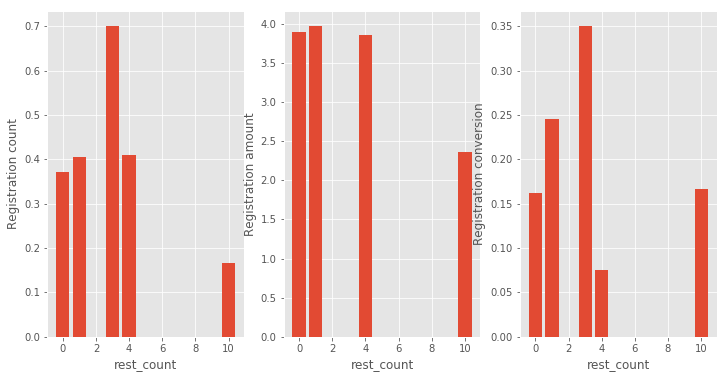

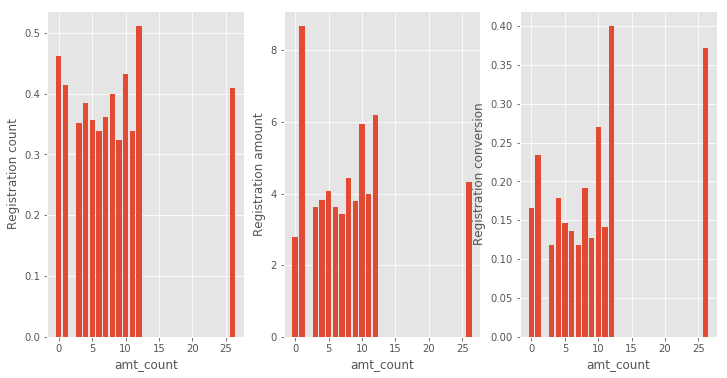

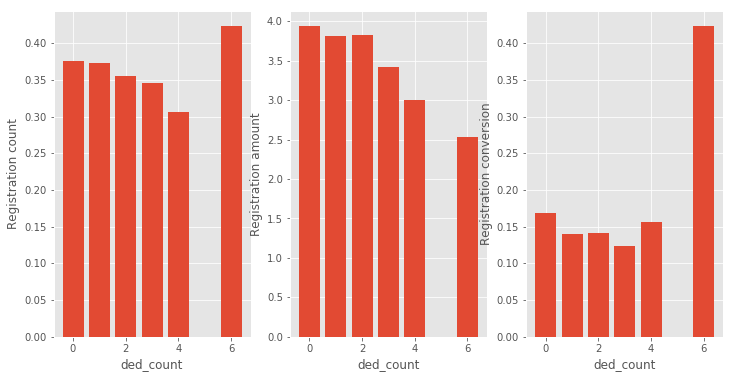

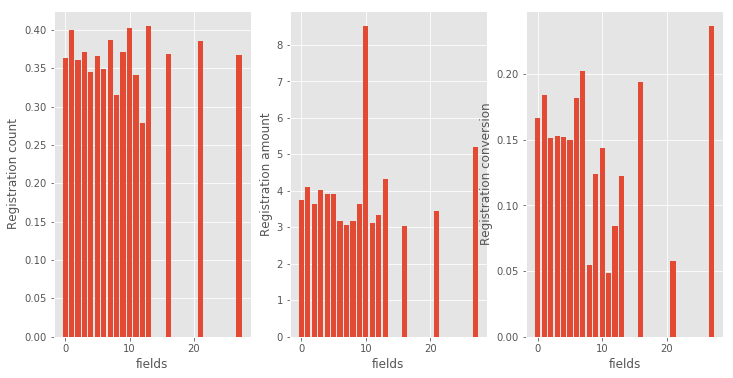

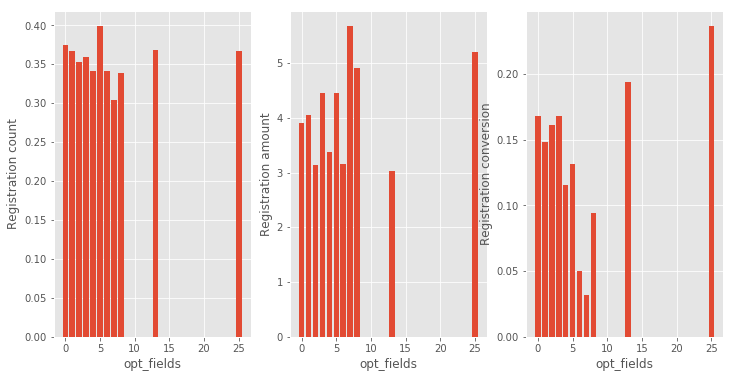

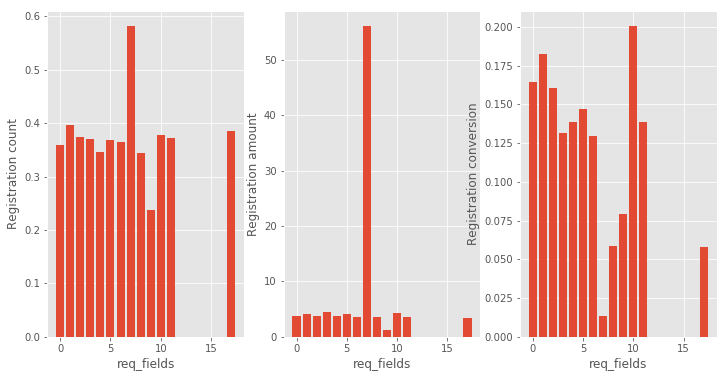

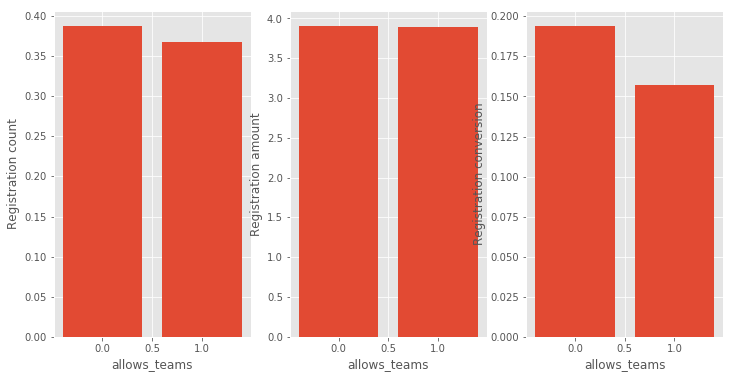

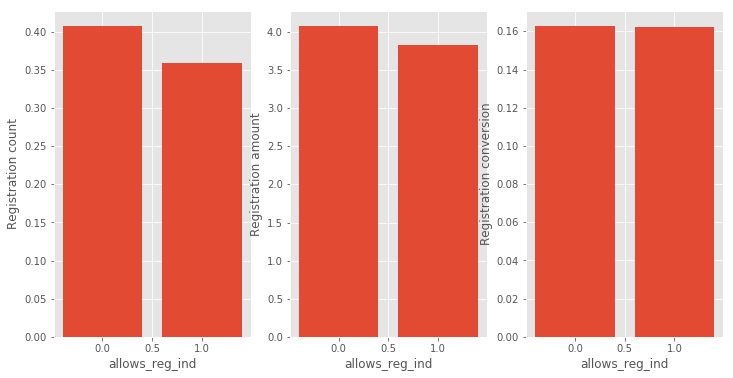

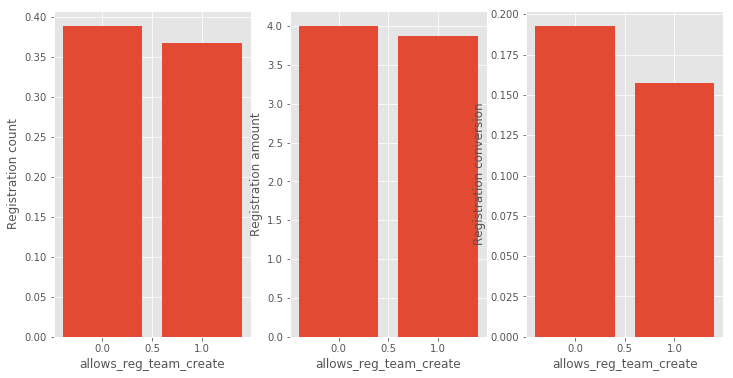

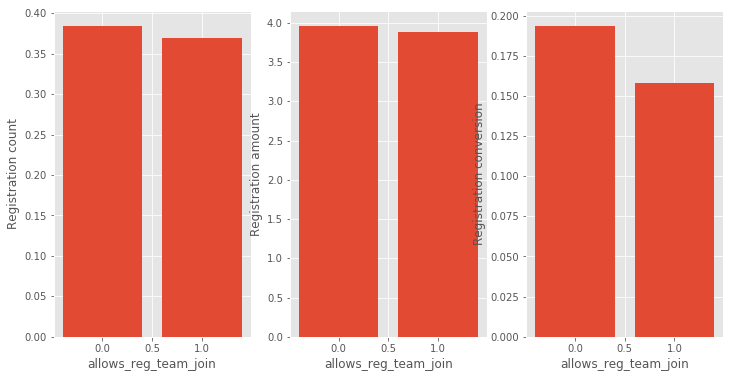

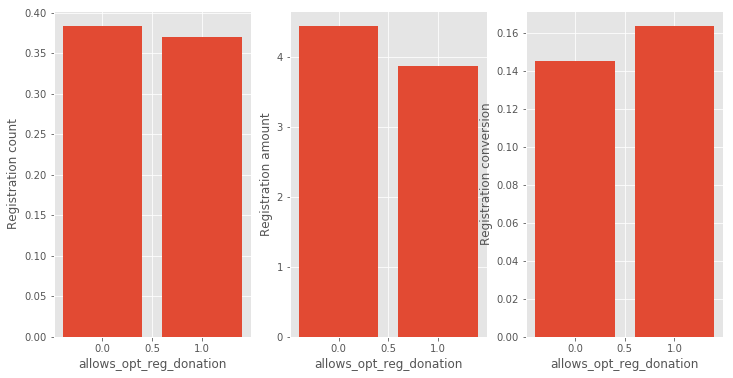

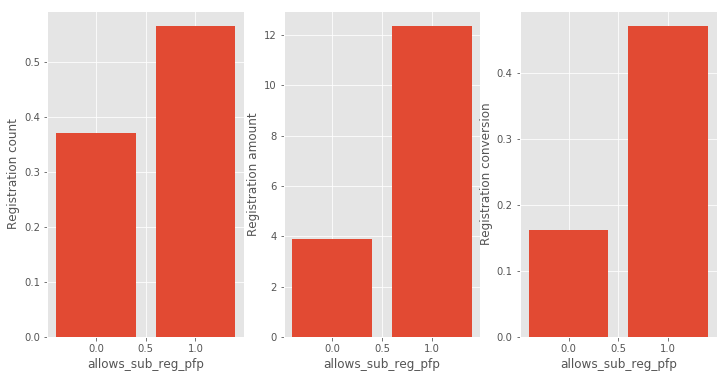

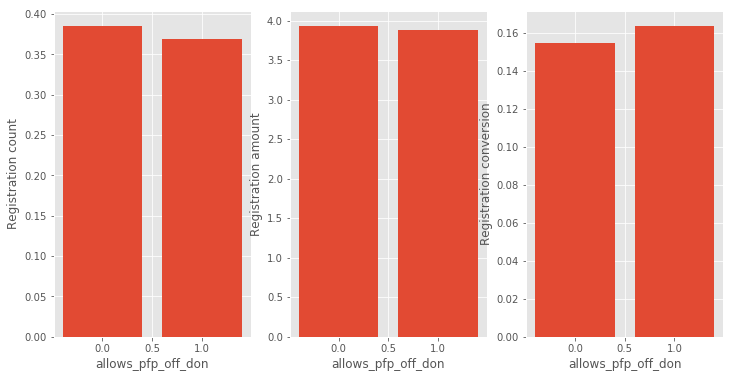

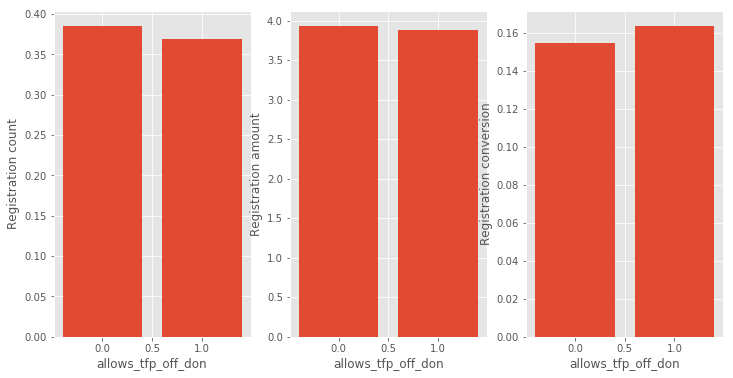

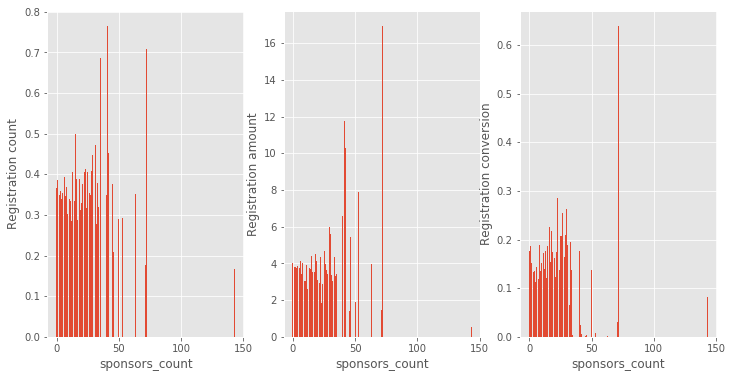

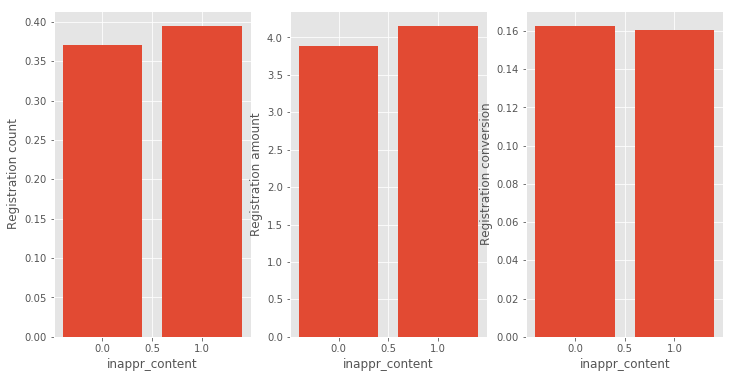

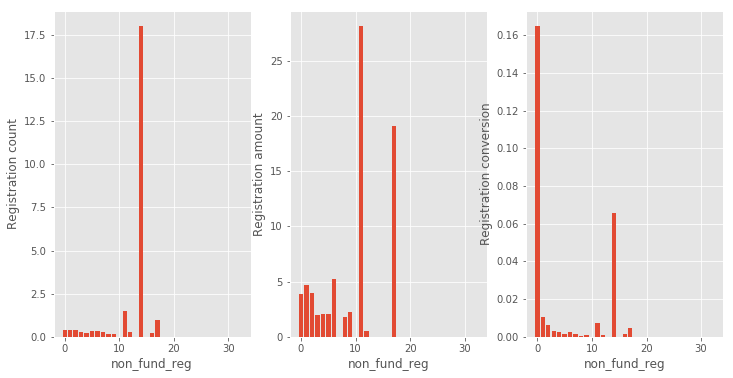

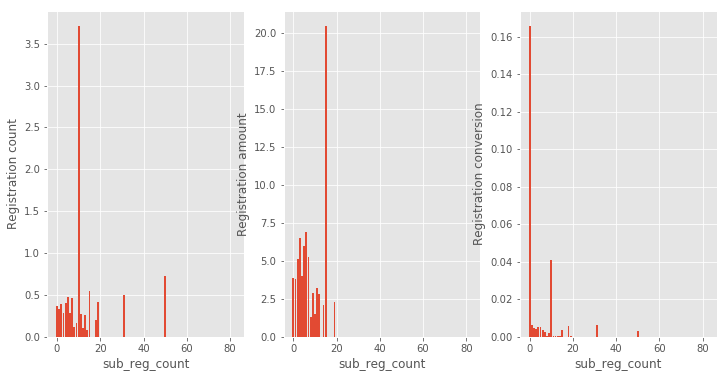

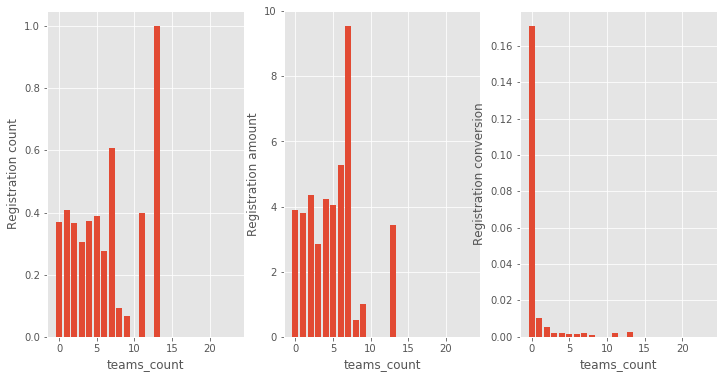

In [20]:
graphed_ftrs = ['rest_count', 'amt_count', 'ded_count', 'fields', 'opt_fields', 'req_fields',
               'allows_teams', 'allows_reg_ind', 'allows_reg_team_create', 'allows_reg_team_join',
               'allows_opt_reg_donation', 'allows_sub_reg_pfp',
               'allows_pfp_off_don', 'allows_tfp_off_don', 'sponsors_count', 
                'inappr_content', 'non_fund_reg', 'sub_reg_count', 'teams_count']
for f in graphed_ftrs:
    data = df[['reg_count', f]].groupby(f)['reg_count'].mean()
    ax1 = plt.subplot(1, 3, 1)
    ax1.bar(data.index, data.values)
    plt.ylabel('Registration count')
    plt.xlabel(f)

    data = df[['reg_amt', f]].groupby(f)['reg_amt'].mean()
    ax2 = plt.subplot(1,3,2)
    ax2.bar(data.index, data.values)
    plt.ylabel('Registration amount')
    plt.xlabel(f)
    
    data = df[['reg_conversion', f]].groupby(f)['reg_conversion'].mean()
    ax2 = plt.subplot(1,3,3)
    ax2.bar(data.index, data.values)
    plt.ylabel('Registration conversion')
    plt.xlabel(f)
    plt.show()

In [11]:
df.columns

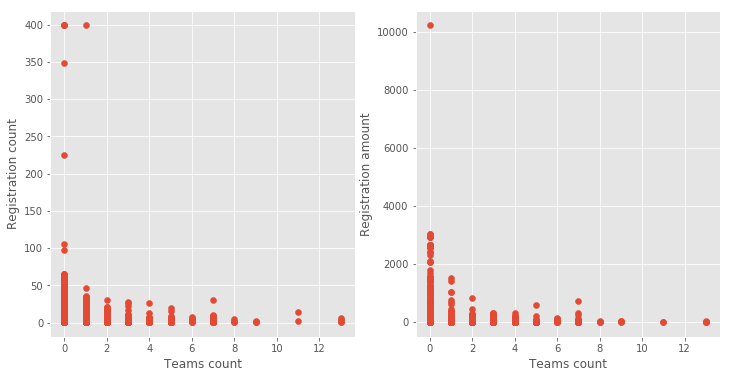

In [10]:
# remove observations without registrations
data = df[df['reg_count']>0][['reg_count', 'teams_count', 'reg_amt']]

ax1 = plt.subplot(1, 2, 1)
ax1.scatter(data['teams_count'], data['reg_count'])
plt.ylabel('Registration count')
plt.xlabel('Teams count')

ax2 = plt.subplot(1,2,2)
ax2.scatter(data['teams_count'], data['reg_amt'])
plt.ylabel('Registration amount')
plt.xlabel('Teams count')
plt.show()

# Feature importances

In [12]:
df = pd.read_csv("~/Repositories/datasets/analytics_p2p_registrations.csv")
df = df[df.visits>0]
# adding conversion variable
df['reg_conversion'] = df['reg_count'] / df['visits']

In [16]:
ftrs = ['class_count', 'cat_count', 'promo_count', 'rest_count', 'amt_count', 'ded_count', 
'fields', 'opt_fields', 'req_fields', 'allows_reg_ind', 'allows_teams', 'allows_reg_team_create', 
'allows_reg_team_join', 'allows_opt_reg_donation', 'allows_sub_reg', 'allows_sub_reg_pfp',
'allows_other_don_amt', 'allows_pfp_off_don', 'allows_tfp_off_don']
X_train, X_test, y_train, y_test = train_test_split(df[ftrs], df['reg_count'], test_size=0.25)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

print("Feature importances:")
for i in range(len((X_train.columns))):
    print("{}: {}".format(X_train.columns[i], rf.feature_importances_[i]))

Feature importances:
class_count: 0.181938850488
cat_count: 0.151247481324
promo_count: 0.17931211281
rest_count: 0.00944088645798
amt_count: 0.111477083997
ded_count: 0.0381741912636
fields: 0.0968182260701
opt_fields: 0.0317915398248
req_fields: 0.0505806477151
allows_reg_ind: 0.0401868769032
allows_teams: 0.02699710467
allows_reg_team_create: 0.0124767124384
allows_reg_team_join: 0.00939778942752
allows_opt_reg_donation: 0.0351419904733
allows_sub_reg: 0.0
allows_sub_reg_pfp: 0.0012304552917
allows_other_don_amt: 7.41087323238e-06
allows_pfp_off_don: 0.013409134774
allows_tfp_off_don: 0.0103715051976
